# Answers to Questions (in LaTeX Markdown)

### Question 3.3.1
**Question:** How many possible codebooks are there given that each codebook is a permutation of the letters A to Z?

**Answer:**
Since each codebook is a permutation of 26 distinct letters, the number of possible codebooks is:
$$
26! \,.
$$

### Question 3.3.2
**Question:** Would it be feasible to calculate $\pi(B)$ directly for a codebook $B$ applied to an encrypted text $C$? Explain the difficulties.

**Answer:**
Direct computation of 
$$
\pi(B) = \frac{1}{Z} \exp\bigl(l(A_B)\bigr)
$$
is not feasible. The difficulties include:

1. **Normalization Constant ($Z$):** To find $Z$, one would need to sum over all $26!$ permutations, which is computationally intractable.
2. **Data Requirements:** Accurately estimating the conditional probabilities $p(\beta|\alpha)$ requires large corpora to obtain reliable frequencies.
3. **Numerical Instability:** Even if we skip computing $Z$, directly computing probabilities for large texts leads to extremely small numbers. We handle this by using logarithms, but enumerating all permutations remains impossible.

Thus, we use MCMC methods like Metropolis-Hastings to sample from $\pi(B)$ without directly computing $Z$ or enumerating all permutations.

### Question 3.3.3
**Question:** Show that the sample “swap chain” on codebooks is a symmetric Markov chain. That is, if $T$ is the Markov transition matrix for the swap chain and $B$ and $B'$ are two possible codebooks, show that $T(B,B')=T(B',B)$.

**Answer:**
The chain proposes a move by selecting two distinct letters at random and swapping their mapped letters. There are $\binom{26}{2} = 325$ equally likely swaps.

- If $B'$ can be reached from $B$ by swapping the images of two letters, say $(X,Y)$, then $B$ can also be reached from $B'$ by swapping the same pair $(X,Y)$ back.  
- The probability of proposing a particular swap is uniform. Thus:
$$
T(B,B') = \frac{1}{325} \quad \text{if $B'$ differs from $B$ by one swap, and } T(B,B')=0 \text{ otherwise.}
$$

Similarly,
$$
T(B',B) = \frac{1}{325}
$$
under the same condition. Hence $T(B,B')=T(B',B)$, showing the chain is symmetric.

### Question 3.3.4
**Question:** What is the acceptance probability if we use a proposal of the simple swap chain in a Metropolis-Hastings MCMC algorithm? Simplify your expression using that the proposal chain is symmetric.

**Answer:**
The Metropolis-Hastings acceptance probability is generally:
$$
\alpha(B,B') = \min\left(1,\frac{\pi(B')T(B',B)}{\pi(B)T(B,B')}\right)\,.
$$

Since the proposal is symmetric, we have:
$$
T(B',B)=T(B,B')\,.
$$

Thus, the acceptance probability simplifies to:
$$
\alpha(B,B') = \min\left(1,\frac{\pi(B')}{\pi(B)}\right) = \min\bigl(1,\exp(l(A_{B'})-l(A_B))\bigr)\,.
$$

This means we accept the proposed swap if it improves the log-likelihood or, if not, we accept it with a probability proportional to the ratio $\exp(l(A_{B'})-l(A_B))$.

---

# Code Implementation


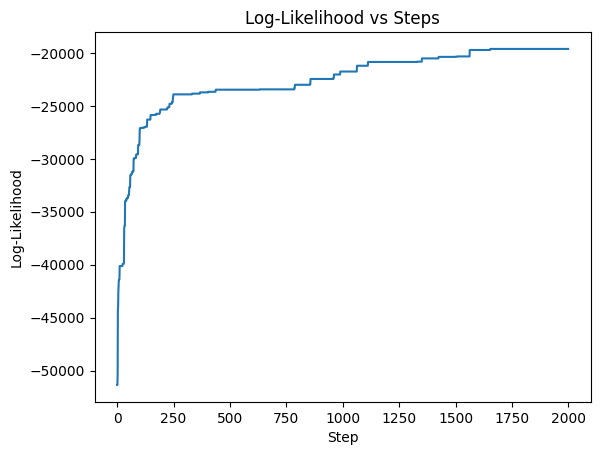

Best Decoded Text:
WHEN ON THE CIURSE IF HUMAN EVENTS OT BECIMES NECESSARY FIR INE PEIPLE TI DOSSILVE THE PILOTOCAL BANDS WHOCH HAVE CINNECTED THEM WOTH ANITHER AND TI ASSUME AMING THE PIWERS IF THE EARTH THE SEPARATE AND EJUAL STATOIN TI WHOCH THE LAWS IF NATURE AND IF NATURES GID ENTOTLE THEM A DECENT RESPECT TI THE IPONOINS IF MANKOND REJUORES THAT THEY SHIULD DECLARE THE CAUSES WHOCH OMPEL THEM TI THE SEPARATOIN WE HILD THESE TRUTHS TI BE SELFEVODENT THAT ALL MEN ARE CREATED EJUAL THAT THEY ARE ENDIWED BY THEOR CREATIR WOTH CERTAON UNALOENABLE ROGHTS THAT AMING THESE ARE LOFE LOBERTY AND THE PURSUOT IF HAPPONESS THAT TI SECURE THESE ROGHTS GIVERNMENTS ARE ONSTOTUTED AMING MEN DEROVONG THEOR QUST PIWERS FRIM THE CINSENT IF THE GIVERNED THAT WHENEVER ANY FIRM IF GIVERNMENT BECIMES DESTRUCTOVE IF THESE ENDS OT OS THE ROGHT IF THE PEIPLE TI ALTER IR TI ABILOSH OT AND TI ONSTOTUTE NEW GIVERNMENT LAYONG OTS FIUNDATOIN IN SUCH PRONCOPLES AND IRGANOZONG OTS PIWERS ON SUCH FIRM AS TI THEM S

In [4]:

import random as rnd
import math
import copy
import matplotlib.pyplot as plt

# Function to check characters
def okChar(c):
    return (('A' <= c <= 'Z') or c == ' ')

# Clean and preprocess text
def cleanText(data):
    data = data.upper()
    makeSpacesChar = [',', '!', '?', ';', '.', ':']
    for i in range(10):
        makeSpacesChar.append(str(i))
    for c in makeSpacesChar:
        data = data.replace(c, ' ')
    data = ' '.join(data.split())
    onlyGoodChar = [c for c in data if (('A' <= c <= 'Z') or (c == ' '))]
    return ''.join(onlyGoodChar)

# Count pairs
def addCounts(pairDictionary, data):
    for i in range(len(data)-1):
        c1 = data[i]
        c2 = data[i+1]
        if okChar(c1) and okChar(c2):
            key = (c1, c2)
            pairDictionary[key] = pairDictionary.get(key, 0) + 1

# Generate a random codebook (A permutation of A-Z)
def randomCodeBook():
    alpha = [chr(c) for c in range(ord('A'), ord('A')+26)]
    alpha2 = alpha.copy()
    rnd.shuffle(alpha2)
    return {a: code for a, code in zip(alpha, alpha2)}

# Invert the codebook
def invert_code_book(codeBook):
    return {v: k for k, v in codeBook.items()}

# Apply a codebook to text
def applyCodeBook(text, code_book):
    out = []
    for c in text:
        if c == ' ':
            out.append(' ')
        elif okChar(c):
            out.append(code_book[c])
    return ''.join(out)

# Perform a random swap in a codebook
def randSwapInCodeBook(codebook):
    new_codebook = copy.deepcopy(codebook)
    o = rnd.sample(list(new_codebook.keys()), 2)
    new_codebook[o[0]], new_codebook[o[1]] = new_codebook[o[1]], new_codebook[o[0]]
    return new_codebook

# Compute the log-likelihood of a text under the learned model
def log_likelihood(text, pair_dict, epsilon=math.exp(-16)):
    ll = 0.0
    for i in range(len(text)-1):
        c1, c2 = text[i], text[i+1]
        p = pair_dict.get((c1,c2), epsilon)
        if p < epsilon:
            p = epsilon
        ll += math.log(p)
    return ll

# Load training data and build conditional probabilities
fileNames = ["emma.txt", "journey.txt"]

pairDictionary = {}
directory = "Data/"
for fileName in fileNames:
    with open(directory+fileName, 'r') as file:
        data = file.read().replace('\n', '')
    data = cleanText(data)
    addCounts(pairDictionary, data)

# Convert pair counts to conditional probabilities
total_counts = {}
for (c1, c2), count in pairDictionary.items():
    total_counts[c1] = total_counts.get(c1, 0) + count

pair_dict = {pair: pairDictionary[pair]/total_counts[pair[0]] for pair in pairDictionary}

# Load the encrypted message
with open("encoded.txt", "r") as file_tag:
    encoded_text = file_tag.read()
encoded_text = cleanText(encoded_text)

# Metropolis-Hastings MCMC
def metropolis_hastings(encoded_text, pair_dict, steps=2000):
    current_codebook = randomCodeBook()
    current_decodebook = invert_code_book(current_codebook)
    current_decoded = applyCodeBook(encoded_text, current_decodebook)
    current_ll = log_likelihood(current_decoded, pair_dict)

    best_ll = current_ll
    best_codebook = copy.deepcopy(current_codebook)
    ll_trace = []

    for step in range(steps):
        proposed_codebook = randSwapInCodeBook(current_codebook)
        proposed_decodebook = invert_code_book(proposed_codebook)
        proposed_decoded = applyCodeBook(encoded_text, proposed_decodebook)
        proposed_ll = log_likelihood(proposed_decoded, pair_dict)

        diff = proposed_ll - current_ll
        # Bound diff to avoid overflow
        if diff > 700:
            accept_prob = 1.0
        elif diff < -700:
            accept_prob = 0.0
        else:
            accept_prob = min(1.0, math.exp(diff))

        if rnd.random() < accept_prob:
            current_codebook = proposed_codebook
            current_ll = proposed_ll
            if current_ll > best_ll:
                best_ll = current_ll
                best_codebook = copy.deepcopy(current_codebook)
        ll_trace.append(current_ll)

    return best_codebook, ll_trace

best_codebook, ll_trace = metropolis_hastings(encoded_text, pair_dict, steps=2000)
best_decodebook = invert_code_book(best_codebook)
best_decrypted = applyCodeBook(encoded_text, best_decodebook)

plt.plot(ll_trace)
plt.xlabel("Step")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood vs Steps")
plt.show()

print("Best Decoded Text:")
print(best_decrypted)

